# Data Cleaning and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Load data
data = pd.read_csv('Boston_Home.csv')

# 1. Handling Missing Values
# Dropping rows where essential columns (like shooter, shot_team, shot_outcome) are missing
data = data.dropna(subset=['shooter', 'shot_team', 'shot_outcome'])

# 2. Convert Data Types
# Convert time-related columns to numeric types where necessary
data['secs_remaining'] = pd.to_numeric(data['secs_remaining'], errors='coerce')
data['secs_remaining_absolute'] = pd.to_numeric(data['secs_remaining_absolute'], errors='coerce')
data['three_pt'] = data['three_pt'].astype(bool)
data['free_throw'] = data['free_throw'].astype(bool)

# 3. Feature Engineering
# Categorize 'score_diff' into close game situations
data['score_diff_category'] = pd.cut(data['score_diff'], bins=[-np.inf, -3, 3, np.inf], labels=['Losing', 'Close', 'Winning'])

# Adding 'clutch_time' feature if less than 2 minutes remain
data['clutch_time'] = data['secs_remaining'] <= 120  # 120 seconds = 2 minutes

# Preview the cleaned dataset
data.head(5)


,game_id,date,home,away,play_id,half,time_remaining_half,secs_remaining,secs_remaining_absolute,description,...,attendance,shot_team,shot_outcome,shooter,three_pt,free_throw,possession_before,possession_after,score_diff_category,clutch_time
0,401576156,11/6/2023,Boston College,Fairfield,1,1,19:42,2382,2382,Prince Aligbe made Layup.,...,4736,Boston College,made,Prince Aligbe,False,False,Boston College,Fairfield,Close,False
1,401576156,11/6/2023,Boston College,Fairfield,2,1,19:24,2364,2364,Jasper Floyd made Three Point Jumper. Assisted...,...,4736,Fairfield,made,Jasper Floyd,True,False,Fairfield,Boston College,Close,False
4,401576156,11/6/2023,Boston College,Fairfield,5,1,18:28,2308,2308,Quinten Post missed Layup.,...,4736,Boston College,missed,Quinten Post,False,False,Boston College,Boston College,Close,False
6,401576156,11/6/2023,Boston College,Fairfield,7,1,18:24,2304,2304,Quinten Post made Layup.,...,4736,Boston College,made,Quinten Post,False,False,Boston College,Fairfield,Close,False
9,401576156,11/6/2023,Boston College,Fairfield,10,1,18:05,2285,2285,Jaeden Zackery missed Layup.,...,4736,Boston College,missed,Jaeden Zackery,False,False,Boston College,Fairfield,Close,False


# Exploratory Data Analysis (EDA)

## Player Shooting Performance: Analyze each player’s shooting performance in different situations.

In [2]:
# Calculate shooting accuracy for each player
player_stats = data.groupby('shooter').agg(
    total_shots=('shot_outcome', 'count'),
    made_shots=('shot_outcome', lambda x: (x == 'made').sum()),
    three_pt_attempts=('three_pt', 'sum')
).reset_index()
player_stats['shooting_accuracy'] = player_stats['made_shots'] / player_stats['total_shots']
player_stats['three_pt_accuracy'] = data[data['three_pt']].groupby('shooter')['shot_outcome'].apply(lambda x: (x == 'made').mean())

# Display top shooters
player_stats = player_stats.sort_values(by='shooting_accuracy', ascending=False)
print(player_stats.head())


             shooter  total_shots  made_shots  three_pt_attempts  \
168     Zuby Ejiofor            3           3                  0   
21      Brody Limric            1           1                  1   
76         Jake Pike            2           2                  1   
163  Will Batchelder            3           3                  1   
88     Jaylan Gainey            3           3                  0   

     shooting_accuracy  three_pt_accuracy  
168                1.0                NaN  
21                 1.0                NaN  
76                 1.0                NaN  
163                1.0                NaN  
88                 1.0                NaN  


## Performance in Clutch Moments

In [3]:
# Filter for clutch moments and analyze player performance
clutch_data = data[data['clutch_time'] == True]
clutch_performance = clutch_data.groupby('shooter').agg(
    clutch_shots=('shot_outcome', 'count'),
    clutch_made=('shot_outcome', lambda x: (x == 'made').sum())
).reset_index()
clutch_performance['clutch_accuracy'] = clutch_performance['clutch_made'] / clutch_performance['clutch_shots']

# Merging clutch performance with overall player stats for comparison
player_performance = player_stats.merge(clutch_performance, on='shooter', how='left').fillna(0)
print(player_performance.head())

           shooter  total_shots  made_shots  three_pt_attempts  \
0     Zuby Ejiofor            3           3                  0   
1     Brody Limric            1           1                  1   
2        Jake Pike            2           2                  1   
3  Will Batchelder            3           3                  1   
4    Jaylan Gainey            3           3                  0   

   shooting_accuracy  three_pt_accuracy  clutch_shots  clutch_made  \
0                1.0                0.0           0.0          0.0   
1                1.0                0.0           0.0          0.0   
2                1.0                0.0           2.0          2.0   
3                1.0                0.0           2.0          2.0   
4                1.0                0.0           0.0          0.0   

   clutch_accuracy  
0              0.0  
1              0.0  
2              1.0  
3              1.0  
4              0.0  


# Feature Selection and Data Preparation


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Filter for clutch moments (last 2 minutes) and prepare the data for prediction
clutch_data = data[data['secs_remaining'] <= 120]  # Clutch moments filter

# Encode categorical variables (like shooter and action team)
data['shooter_encoded'] = LabelEncoder().fit_transform(data['shooter'])

# Calculate rolling shooting accuracy for each shooter
data['shooter_made'] = data['shot_outcome'].apply(lambda x: 1 if x == 'made' else 0)
data['shooter_rolling_accuracy'] = data.groupby('shooter')['shooter_made'].transform(lambda x: x.rolling(5, min_periods=1).mean())

data['is_clutch_time'] = data['secs_remaining'] < 120  # Clutch time: last 2 minutes (120 seconds)

data['score_diff_trend'] = data['score_diff'].diff().fillna(0)

data['score_diff_clutch_interaction'] = data['score_diff'] * data['is_clutch_time']

data['score_diff_lag'] = data['score_diff'].shift(1).fillna(0)
data['shooter_rolling_accuracy_lag'] = data['shooter_rolling_accuracy'].shift(1).fillna(data['shooter_rolling_accuracy'].mean())
#features list
# Ensure features is a list of column names
features = ['secs_remaining', 'score_diff', 'three_pt', 'shooter_encoded', 
            'home_time_out_remaining', 'away_time_out_remaining', 
            'shooter_rolling_accuracy', 'is_clutch_time',
            'score_diff_clutch_interaction', 'score_diff_lag', 'shooter_rolling_accuracy_lag']

target = data['shot_outcome'].apply(lambda x: 1 if x == 'made' else 0)  # Binary target for shot success

# Model for finding recommend Player for Winning Shot

## XGBoost Model

In [32]:
# Define features and target
X = data[features]  # This is the feature matrix
y = target          # This is the target series

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Initialize the XGBoost model with best parameters found or default ones
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,    # L1 regularization term
    reg_lambda=0.1,   # L2 regularization term
    random_state=42,
    eval_metric='logloss'
)

# Isolate data for clutch moments
clutch_data = data[data['is_clutch_time'] == True]
X_clutch = clutch_data[features]
shooters = clutch_data['shooter'].values

# Train the model
xgb_model.fit(X_train, y_train)

# Predict and evaluate the model
xgb_pred = xgb_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
# Predict shot success probability using only the XGBoost model
xgb_probs = xgb_model.predict_proba(X_clutch)[:, 1]  # XGBoost shot success probabilities
clutch_data['shot_success_probability'] = xgb_probs

# Group by each shooter to get their average clutch shot success probability
recommendation = clutch_data.groupby('shooter').agg(
    avg_shot_success_prob=('shot_success_probability', 'mean'),
    clutch_shots=('shot_success_probability', 'count')
).reset_index()

# Sort by shot success probability to recommend the best shooter for a clutch shot
recommendation = recommendation.sort_values(by='avg_shot_success_prob', ascending=False)
print("Top shooters for clutch situations:\n", recommendation.head())

# Final recommendation for the winning shot
best_player = recommendation.iloc[0]['shooter']
print(f"\nRecommended player for the winning shot is: {best_player}")


Test Accuracy: 0.7625570776255708
Test F1 Score: 0.7753779697624188
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       402
           1       0.79      0.76      0.78       474

    accuracy                           0.76       876
   macro avg       0.76      0.76      0.76       876
weighted avg       0.76      0.76      0.76       876

Top shooters for clutch situations:
             shooter  avg_shot_success_prob  clutch_shots
44     Kevin Miller               0.993735             1
32        Jake Pike               0.990506             2
68  Will Batchelder               0.990051             2
65      Tre Breland               0.986124             1
40    Josiah Strong               0.912290             1

Recommended player for the winning shot is: Kevin Miller


C:\Users\sejal\AppData\Local\Temp\ipykernel_23236\3819270795.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_data['shot_success_probability'] = xgb_probs


## Random Forest Classifier

In [37]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train a Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Model evaluation
r_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, r_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, r_pred))

# Prepare input for prediction
X_clutch = clutch_data[features]
shooters = clutch_data['shooter'].values

# Predict shot success probability using only the Random Forest model
rf_probs = model.predict_proba(X_clutch)[:, 1]  # Random Forest shot success probabilities
clutch_data['shot_success_probability'] = rf_probs

# Group by each shooter to get their average clutch shot success probability
recommendation = clutch_data.groupby('shooter').agg(
    avg_shot_success_prob=('shot_success_probability', 'mean'),
    clutch_shots=('shot_success_probability', 'count')
).reset_index()

# Sort by shot success probability to recommend the best shooter for a clutch shot
recommendation = recommendation.sort_values(by='avg_shot_success_prob', ascending=False)
print("Top shooters for clutch situations:\n", recommendation.head())

# Final recommendation for the winning shot
best_player = recommendation.iloc[0]['shooter']
print(f"\nRecommended player for the winning shot is: {best_player}")


Accuracy: 0.7157534246575342
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71       402
           1       0.76      0.69      0.72       474

    accuracy                           0.72       876
   macro avg       0.72      0.72      0.72       876
weighted avg       0.72      0.72      0.72       876

Top shooters for clutch situations:
             shooter  avg_shot_success_prob  clutch_shots
68  Will Batchelder                   0.99             2
62    Reece Beekman                   0.97             2
54   Nique Clifford                   0.94             1
44     Kevin Miller                   0.93             1
63     Seth Trimble                   0.93             1

Recommended player for the winning shot is: Will Batchelder


C:\Users\sejal\AppData\Local\Temp\ipykernel_23236\160689644.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_data['shot_success_probability'] = rf_probs


## Logistic Regression Model

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Assuming `features` and `target` are already defined, and data split is required
# Split the data
X_train, X_test, y_train, y_test = train_test_split(data[features], target, test_size=0.3, random_state=42)

# Step 1: Initialize and Train Logistic Regression Model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear')
log_reg_model.fit(X_train, y_train)

# Step 2: Evaluate Model Performance
y_pred = log_reg_model.predict(X_test)
y_pred_proba = log_reg_model.predict_proba(X_test)[:, 1]  # Probabilities for shot success

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Logistic Regression Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 3: Use the Model for Clutch Shot Recommendations
# Filter clutch data
clutch_data = data[data['secs_remaining'] <= 120]
X_clutch = clutch_data[features]

# Predict clutch shot success probability
clutch_data['shot_success_probability'] = log_reg_model.predict_proba(X_clutch)[:, 1]

# Aggregate shot success probability by shooter
recommendation = clutch_data.groupby('shooter').agg(
    avg_shot_success_prob=('shot_success_probability', 'mean'),
    clutch_shots=('shot_success_probability', 'count')
).reset_index()

# Sort by shot success probability to find the best recommendation
recommendation = recommendation.sort_values(by='avg_shot_success_prob', ascending=False)
print("\nTop shooters for clutch situations based on Logistic Regression:\n", recommendation.head())

# Best recommendation for the winning shot
best_player = recommendation.iloc[0]['shooter']
print(f"\nRecommended player for the winning shot based on Logistic Regression is: {best_player}")


Logistic Regression Model Performance:
Accuracy: 0.7408675799086758
Precision: 0.7726269315673289
Recall: 0.7383966244725738
F1 Score: 0.7551240560949297

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.74      0.72       402
           1       0.77      0.74      0.76       474

    accuracy                           0.74       876
   macro avg       0.74      0.74      0.74       876
weighted avg       0.74      0.74      0.74       876


Top shooters for clutch situations based on Logistic Regression:
                shooter  avg_shot_success_prob  clutch_shots
44        Kevin Miller               0.945112             1
32           Jake Pike               0.937003             2
68     Will Batchelder               0.936132             2
11  Carlton Carrington               0.919513             1
65         Tre Breland               0.889834             1

Recommended player for the winning shot based on Logistic Regressi

C:\Users\sejal\AppData\Local\Temp\ipykernel_23236\1418031872.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_data['shot_success_probability'] = log_reg_model.predict_proba(X_clutch)[:, 1]


## Gradient Boosting Model

In [31]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data[features], target, test_size=0.3, random_state=42)

# Step 1: Initialize and Train Gradient Boosting Model
# Set parameters such as number of estimators and learning rate
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)

# Step 2: Evaluate Model Performance
y_pred = gb_model.predict(X_test)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]  # Probabilities for shot success

# Performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Gradient Boosting Model Performance:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Step 3: Use the Model for Clutch Shot Recommendations
# Filter clutch data
clutch_data = data[data['secs_remaining'] <= 120]
X_clutch = clutch_data[features]

# Predict clutch shot success probability
clutch_data['shot_success_probability'] = gb_model.predict_proba(X_clutch)[:, 1]

# Aggregate shot success probability by shooter
recommendation = clutch_data.groupby('shooter').agg(
    avg_shot_success_prob=('shot_success_probability', 'mean'),
    clutch_shots=('shot_success_probability', 'count')
).reset_index()

# Sort by shot success probability to find the best recommendation
recommendation = recommendation.sort_values(by='avg_shot_success_prob', ascending=False)
print("\nTop shooters for clutch situations based on Gradient Boosting:\n", recommendation.head())

# Best recommendation for the winning shot
best_player = recommendation.iloc[0]['shooter']
print(f"\nRecommended player for the winning shot based on Gradient Boosting is: {best_player}")


Gradient Boosting Model Performance:
Accuracy: 0.7625570776255708
Precision: 0.7942477876106194
Recall: 0.7573839662447257
F1 Score: 0.7753779697624188

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.77      0.75       402
           1       0.79      0.76      0.78       474

    accuracy                           0.76       876
   macro avg       0.76      0.76      0.76       876
weighted avg       0.76      0.76      0.76       876


Top shooters for clutch situations based on Gradient Boosting:
             shooter  avg_shot_success_prob  clutch_shots
44     Kevin Miller               0.979988             1
65      Tre Breland               0.974275             1
32        Jake Pike               0.973182             2
68  Will Batchelder               0.970162             2
40    Josiah Strong               0.914063             1

Recommended player for the winning shot based on Gradient Boosting is: Kevin Miller


C:\Users\sejal\AppData\Local\Temp\ipykernel_23236\142248689.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clutch_data['shot_success_probability'] = gb_model.predict_proba(X_clutch)[:, 1]


# Visualization

## Model Evaluation and Feature Importance

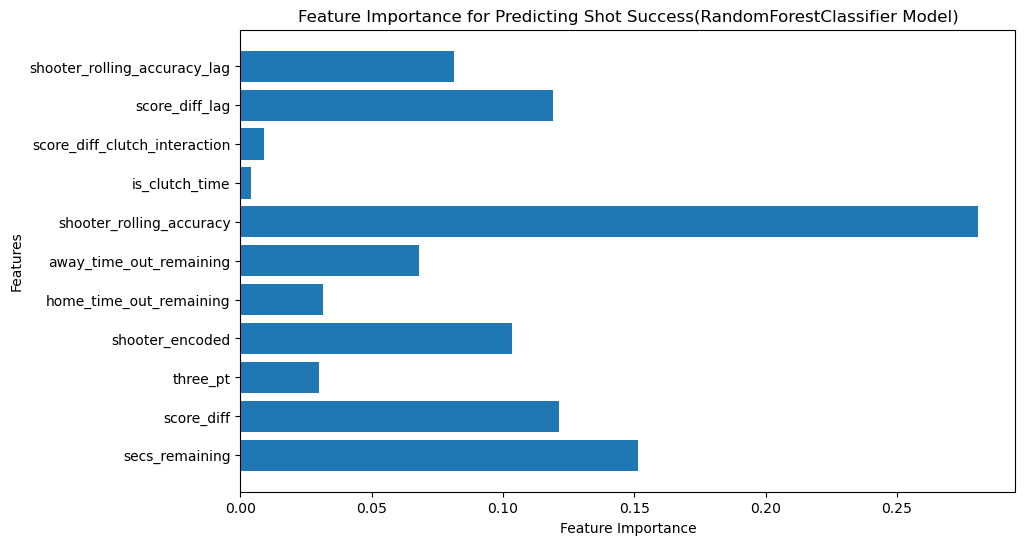

In [34]:
import matplotlib.pyplot as plt

# Feature importance from the Random Forest model
feature_importance = model.feature_importances_
feature_names = features.columns

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Predicting Shot Success(RandomForestClassifier Model)")
plt.show()

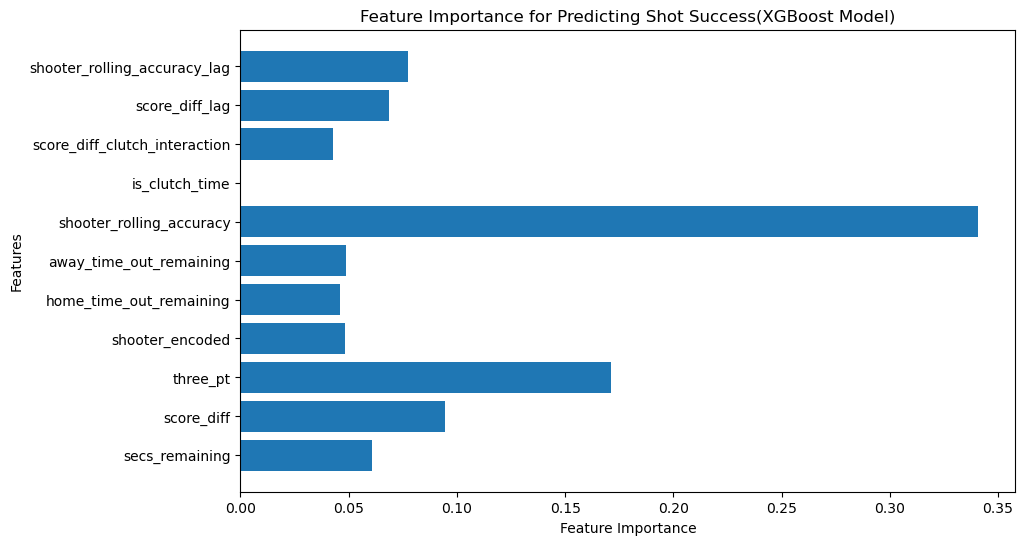

In [35]:
import matplotlib.pyplot as plt

# Feature importance from the Random Forest model
feature_importance = xgb_model.feature_importances_
feature_names = features.columns

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance for Predicting Shot Success(XGBoost Model)")
plt.show()

## Model Performance: Classification Report as Heatmap

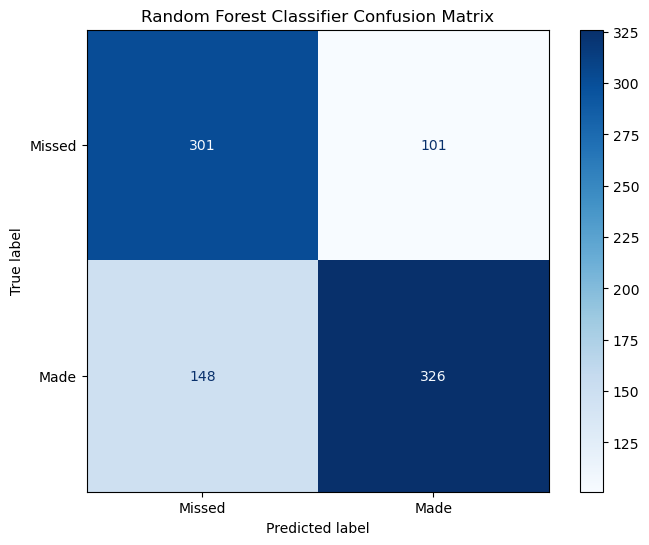

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, r_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Missed", "Made"])
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Random Forest Classifier Confusion Matrix")
plt.show()


### Conclusion The confusion matrix shows that the model is effective in predicting both "Made" and "Missed" shots, with a reasonable level of accuracy. However, there’s room for improvement, particularly in reducing false positives and false negatives. Depending on the primary objective (e.g., maximizing successful shot predictions or minimizing incorrect recommendations), targeted adjustments can be made to enhance the model’s precision or recall.

## Clutch Shot Counts of Top Shooters

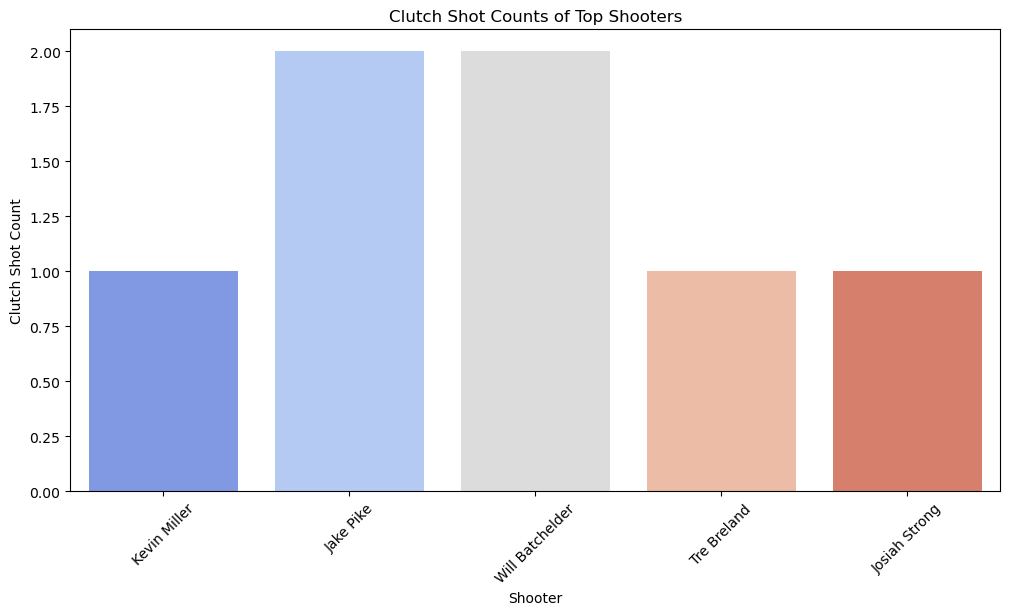

In [63]:
plt.figure(figsize=(12, 6))
sns.barplot(data=recommendation.head(), x='shooter', y='clutch_shots', palette='coolwarm')
plt.title('Clutch Shot Counts of Top Shooters')
plt.xlabel('Shooter')
plt.ylabel('Clutch Shot Count')
plt.xticks(rotation=45)
plt.show()

## Average Clutch Shot Success Probability

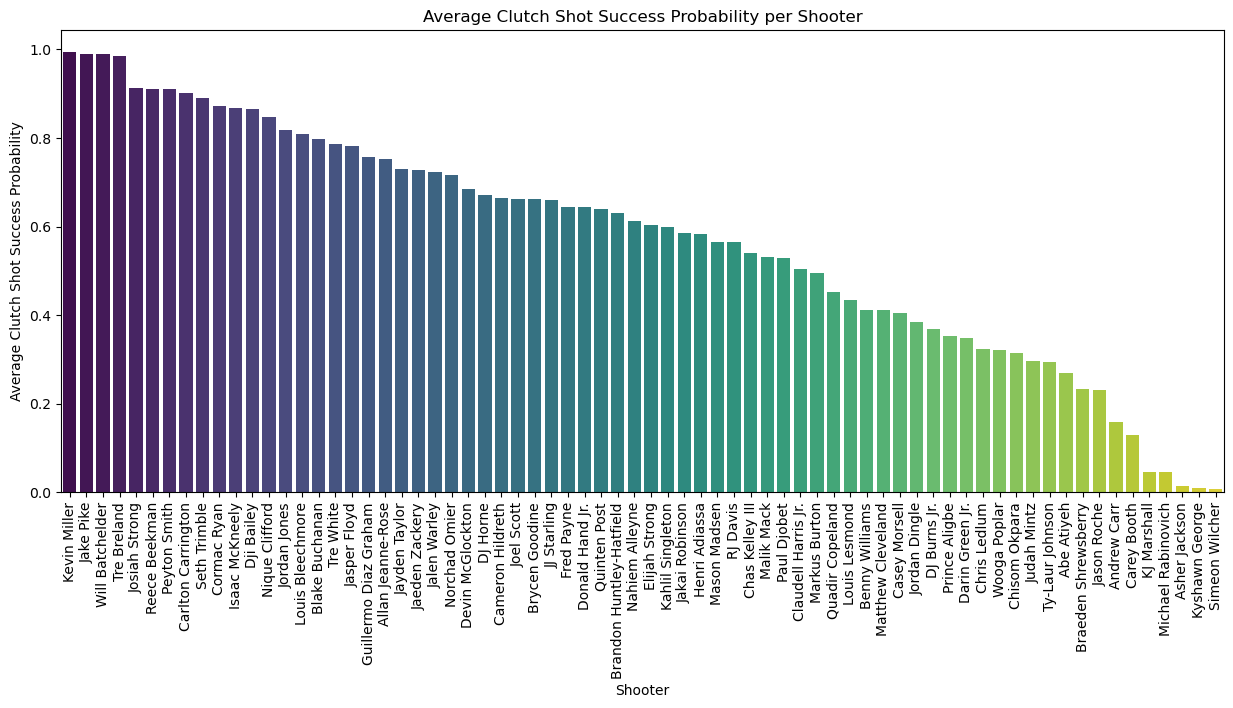

In [66]:
import seaborn as sns

# Plot the average clutch shot success probability per shooter
plt.figure(figsize=(15, 6))
sns.barplot(data=recommendation, x='shooter', y='avg_shot_success_prob', palette='viridis')
plt.title('Average Clutch Shot Success Probability per Shooter')
plt.xlabel('Shooter')
plt.ylabel('Average Clutch Shot Success Probability')
plt.xticks(rotation=90)
plt.show()